## Heston Model
\begin{align}
dS_t &= r S_t \, dt + \sqrt{V_t} S_t \, dW_{1t}, \\
dV_t &= k (\theta - V_t) \, dt + \sigma \sqrt{V_t} \, dW_{2t}
\end{align}


\begin{aligned}
S_t &: \text{the asset price at time } t \\
r &: \text{risk-free interest rate (the theoretical interest rate on an asset that carries no risk)} \\
\sqrt{V_t} &: \text{volatility (standard deviation) of the asset price} \\
\sigma &: \text{volatility of the volatility } \sqrt{V_t} \\
\theta &: \text{long-term price variance} \\
k &: \text{rate of reversion to the long-term price variance} \\
dt &: \text{indefinitely small positive time increment} \\
W_{1t} &: \text{Brownian motion of the asset price} \\
W_{2t} &: \text{Brownian motion of the asset’s price variance} \\
\rho &: \text{correlation coefficient for } W_{1t} \text{ and } W_{2t}
\end{aligned}
d{aligned}


In [3]:
# !pip install yfinance --upgrade --no-cache-dir
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import yfinance as yf
import sympy as sp

# Download stock data for Apple Inc. (AAPL)
data = yf.download('USDMYR=X', start='2002-01-01', end='2024-12-31')

[*********************100%***********************]  1 of 1 completed


Price,Close
Ticker,USDMYR=X
Date,
2003-12-01,3.7968
2003-12-02,3.7971
2003-12-03,3.7902
2003-12-04,3.7987
2003-12-05,3.7896
...,...
2024-12-16,4.4475
2024-12-17,4.4500


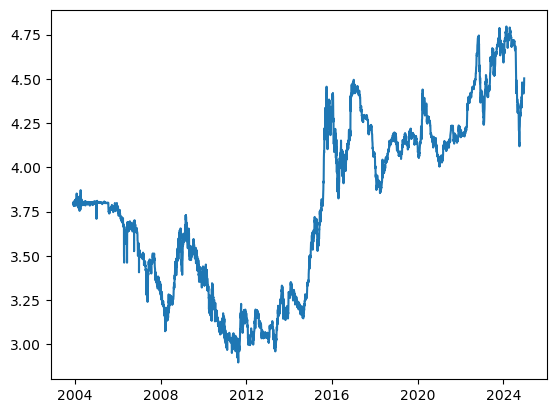

In [15]:
price = data[['Close']]
plt.plot(price)
price

4188
[{k: 2.00000030450784, sigma: -2.92625566248810e-5}, {k: 2.00000030450784, sigma: 2.92625566248810e-5}]
7.99366545716218e-05 2.00000030450784 1.0760227130646172e-05 -2.92625566248810e-5


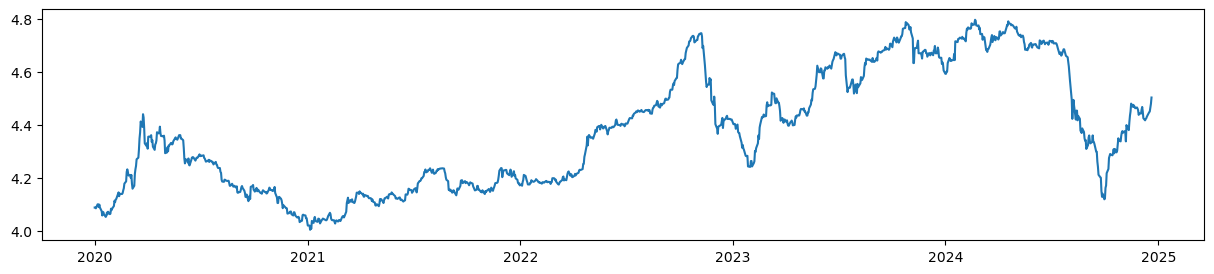

In [40]:
# Moment of estimation 

# Start from 2020-01-01
# Reason 1: Linear trend (since 2016)
# Reason 2: Yield real number sigma (others yield Im)
index = (price.index.get_indexer(price.index[price.index.year == 2020])[0])
print(index)
plt.figure(figsize=(15,3))
plt.plot(price[index:])
p = price[index:]


# Moment
Q = p.values[1:] / p.values[:-1]
# print(Q, len(Q))
m1 = np.mean(Q)
m2 = np.mean(Q**2)
m4 = np.mean(Q**4)
m5 = np.mean(Q**5)

k = sp.Symbol('k')
sigma = sp.Symbol('sigma')

r = m1 - 1

theta = m2 - (r+1)**2

mu_4 = (1 / (k * (k - 2))) * (
    k**2 * r**4 + 4 * k**2 * r**3 + 6 * k**2 * r**2 * theta - 2 * k * r**4 + 6 * k**2 * r**2 + 
    12 * k**2 * r * theta + 3 * k**2 * theta**2 - 8 * k * r**3 - 12 * k * r**2 * theta + 
    4 * k**2 * r + 6 * k**2 * theta - 12 * k * r**2 - 24 * k * r * theta - 6 * k * theta**2 - 
    3 * sigma**2 * theta + k**2 - 8 * k * r - 12 * k * theta - 2 * k
)

mu_5 = (1 / (k * (k - 2))) * (
    k**2 * r**5 + 5 * k**2 * r**4 + 10 * k**2 * r**3 * theta - 2 * k * r**5 + 10 * k**2 * r**3 + 
    30 * k**2 * r**2 * theta + 15 * k**2 * r * theta**2 - 10 * k * r**4 - 20 * k * r**3 * theta + 
    10 * k**2 * r**2 + 30 * k**2 * r * theta + 15 * k**2 * theta**2 - 20 * k * r**3 - 60 * k * r**2 * theta - 
    30 * k * r * theta**2 - 15 * r * sigma**2 * theta + 5 * k**2 * r + 10 * k**2 * theta - 
    20 * k * r**2 - 60 * k * r * theta - 30 * k * theta**2 - 15 * sigma**2 * theta + 
    k**2 - 10 * k * r - 20 * k * theta - 2 * k
)

eq4 = sp.Eq(mu_4, m4)
eq5 = sp.Eq(mu_5, m5)

sol = sp.solve([eq4, eq5], (k, sigma), dict=True)
print(sol)


k = sol[0][k]; sigma = sol[0][sigma]
print(r, k, theta, sigma)

# # dW1 = rho*dW2 + sqrt(1-rho**2)*dW1

In [58]:
def heston_model(S0, V0, T, r, k, theta, sigma, rho):

    # dt = 1 (1 estimation per day)
    S = np.zeros(T+1)
    v = np.zeros(T+1)
    S[0] = S0
    v[0] = V0
    
    for t in range(T):
        z1 = np.random.normal(0, 1) 
        z2 = np.random.normal(0, 1)
        z2 = rho * z1 + np.sqrt(1 - rho**2) * z2  # correlation between z1 z2
        # print(z1,z2)
        # print(S[t],v[t])
        
        # St
        dS = r * S[t] + np.sqrt(v[t]) * S[t] * z1
        S[t+1] = S[t] + dS
        
        # Volatility (Cox-Ingersoll-Ross)
        dv = k * (theta - v[t]) + sigma * np.sqrt(v[t]) * z2
        # Avoid var < 0
        v[t+1] = max(v[t] + dv, 0)
        # print(v[t+1])
    
    return S, v


# This is the same as Q.var() (for last value)
V = pd.DataFrame(Q).rolling(window=len(Q), min_periods=2).var().shift(1)

S0 = price.iloc[-100].values[0]
V0 = V.iloc[-100].values[0]
T = 100 

rmse = []
for rho in np.arange(-1, 1, 0.1):
    temp = []
    for i in range(100):
        estimate_S = heston_model(S0, V0, T, r, k, theta, sigma, rho)[0]
        temp.append(np.sqrt(np.mean((price[-100:].values[0] - estimate_S[i])) ** 2))

    rmse.append(np.mean(temp))
    
# plt.plot(p[-100:].values)
# plt.plot(estimate_S[2])
np.argmin(rmse)
display(pd.DataFrame(rmse))
print(np.mean(rmse))

# heston_model(S0, V0, T, -0.9, k, theta, sigma, 0)[0]

,0
0,0.087029
1,0.077160
2,0.089702
3,0.078553
4,0.087685
5,0.076315
6,0.075988
7,0.070257
8,0.066695
9,0.072391


0.07839974809971698


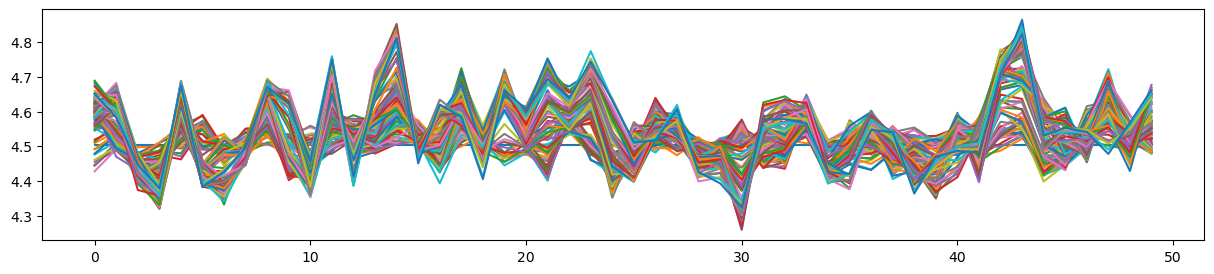

In [55]:
# Prediction
S0 = price.iloc[-1].values[0]
V0 = V.iloc[-1].values[0]
T = 100 

pred = [heston_model(S0, V0, T, r, k, theta, sigma, 0)[0] for i in range(50)]

plt.figure(figsize=(15,3))
plt.plot(pred);



## MLE

\begin{aligned}
\text{Likelihood:} \\[10pt]
L(r, k, \theta, \sigma, \rho) &= \prod_{t=1}^{n} f(Q_{t+1}, V_{t+1} | r, k, \theta, \sigma, \rho) \\
\text{Loglikelihood:} \\[10pt]
\ell(r, k, \theta, \sigma, \rho) &= \sum_{t=1}^{n} \log \left( f(Q_{t+1}, V_{t+1} | r, k, \theta, \sigma, \rho) \right) \\[10pt]
Q_{t+1} &\sim \mathcal{N}(1 + r, V_t) \quad \text{and} \quad V_{t+1} \sim \mathcal{N}(V_t + k(\theta - V_t), \sigma^2 V_t) \\[10pt]
f(Q_{t+1}, V_{t+1}) &= \frac{1}{2 \pi \sigma \sqrt{V_t}} \sqrt{1 - \rho^2} \exp \left( - \frac{(Q_{t+1} - 1 - r)^2}{2 V_t (1 - \rho^2)} + \frac{\rho (Q_{t+1} - 1 - r)(V_{t+1} - V_t - \theta k + k V_t)}{\sigma \sqrt{V_t} (1 - \rho^2)} \right. \\
& \quad \quad \quad \left. - \frac{(V_{t+1} - V_t - \theta k + k V_t)^2}{2 \sigma^2 V_t (1 - \rho^2)} \right) \\[10pt]
(r, k, \theta, \sigma, \rho) &= \prod_{t=1}^{n} \left( -\log(2\pi) - \log(\sigma) - \log(V_t) - \frac{1}{2} \log(1 - \rho^2) \right. \\
& \quad \quad \quad \left. - \frac{(Q_{t+1} - 1 - r)^2}{2V_t(1 - \rho^2)} + \frac{\rho (Q_{t+1} - 1 - r)(V_{t+1} - V_t - \theta k + k V_t)}{V_t \sigma (1 - \rho^2)} \right. \\
& \quad \quad \quad \left. - \frac{(V_{t+1} - V_t - \theta k + k V_t)^2}{2 \sigma^2 V_t (1 - \rho^2)} \right)
\end{aligned}
}
d{aligned}


In [ ]:
# MLE Estimation
# Failed, would not converge
# Start from 2016-01-01
print(price.index.get_indexer(price.index[price.index.year == 2016])[0])
plt.figure(figsize=(15,3))
plt.plot(price[3147:])
p = price[3147:]

Q = p.values[1:] / p.values[:-1]
V = pd.DataFrame(Q).rolling(window=len(Q), min_periods=2).var().shift(1)


def log_likelihood(param, Q, V):
    
    r, k, theta, sigma, rho = param

    n = len(Q)-1
    log_likelihood_value = 0

    # Convert to np.array
    V = np.array(V)
    Q = np.array(Q)

    for t in range(n):
        Vt, Vt1 = V[t], V[t + 1]
        Qt, Qt1 = Q[t], Q[t + 1]
        
        term1 = -np.log(2 * np.pi) - np.log(sigma) - np.log(Vt) - 0.5 * np.log(1 - rho**2)
        term2 = -((Qt1 - 1 - r)**2) / (2 * Vt * (1 - rho**2))
        term3 = rho * (Qt1 - 1 - r) * (Vt1 - Vt - theta * k + k * Vt) / (Vt * sigma * (1 - rho**2))
        term4 = -((Vt1 - Vt - theta * k + k * Vt)**2) / (2 * sigma**2 * Vt * (1 - rho**2))
        
        log_likelihood_value += term1 + term2 + term3 + term4
    
    return -log_likelihood_value  #  negative because minimize


# r k theta sigma rho
initial_guess = [0.01, 2, 0.001, 0.001, 0]

from scipy.optimize import differential_evolution

# Estimate lowest value
# minimize is not used here because it could not converge
result = differential_evolution(log_likelihood, bounds=[(-100, 100), (0, 1000), (0, 100), (0, 100), (-1, 1)],
                                args=(Q, V), maxiter=100000, tol=1e-6)


if result.success:
    print(f"Optimal parameters: r={result.x[0]}, k={result.x[1]}, theta={result.x[2]}, sigma={result.x[3]}, rho={result.x[4]}")
else:
    print("Optimization failed:", result.message)